In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt
import iris.quickplot as qplt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  
#import mo_pack
from matplotlib import ticker, cm
import matplotlib.ticker as mticker
import imageio
import iris.analysis.cartography
from iris.analysis.cartography import _meshgrid, rotate_pole, rotate_winds
from aeolus.coord import get_xy_coords
from iris.coords import AuxCoord
from iris.util import promote_aux_coord_to_dim_coord
import aeolus
from iris.coord_systems import RotatedGeogCS
from aeolus.calc.diag import lat_cos
from iris.util import reverse
from aeolus.calc.stats import cumsum, spatial
from aeolus.coord import roll_cube_pm180, volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels
import matplotlib.colors as colors 
from aeolus.const import init_const
pcb_const=init_const('proxb')
from matplotlib.patches import Rectangle
import scipy
import scipy.fftpack


In [2]:
warnings.filterwarnings("ignore")


# Importing the data

In [3]:
pcb_tl = iris.load('data/pcb_tl_o3circ_8340_900.nc')


In [4]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_tl)


# Functions for statistics, slicing, transformations

In [5]:
def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume


def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    #daymean = meridional_mean(zonal_mean(daycube))
    #nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daycube, nightcube

def height_to_pressure(cube, pressurecube):
    height = [('Hybrid height', cube.coord('Hybrid height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 

def vmr_molec(cube, p_cube, t_cube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = p_cube.interpolate(height, iris.analysis.Linear())
    volume = volume_weights_cube2(cube)
    nair=(p_reg*volume)/((1.38*10**(-23))*t_cube) #nair in molec/gridbox
    cube_molec = cube*nair/volume #n_o3 in molec/m3
    cube_molec *= 1e-6
    return cube_molec

def integrate(cube, coord):
    """
    Integrate the cube along a 1D coordinate using the trapezoidal rule.

    Note: `coord` must be one of the dimensional coordinates of the cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube containing the given coordinate.
    coord: str or iris.coords.Coord
        Coordinate for integration.

    Returns
    -------
    iris.cube.Cube
        Integrated cube.
    """
    # TODO: allow non-dim coordinates
    c = cube.coord(coord)
    others = [dc.name() for dc in cube.dim_coords if cube.coord_dims(dc) != cube.coord_dims(c)]
    dim = cube.coord_dims(c)[0]
    data = np.trapz(cube.data, c.points, axis=dim)
    res = next(cube.slices(others)).copy(data=data)
    res.units = cube.units * c.units
    res.remove_coord(c)
    res.rename(f"integral_of_{cube.name()}_wrt_{c.name()}")
    # ensure_bounds(cube, [c])
    # delta = iris.coords.AuxCoord(c.bounds[:, 1] - c.bounds[:, 0], units=c.units)
    # res = multiply(cube, delta, dim=dim).collapsed(c, iris.analysis.SUM)
    return res

def regrid_to_rotated_pole_coordinates(cube, pole_lon, pole_lat, model=aeolus.model.um):
    """
    Regrid a cube to rotated-pole coordinates.

    Note: non-dimensional coordinates are lost.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube.
    pole_lon: float
        New North Pole longitude.
    pole_lat: float
        New North Pole latitude.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate and variable names.
    """
    _cs = cube.coord_system()
    xcoord, ycoord = get_xy_coords(cube, model=model)
    lon2d, lat2d = _meshgrid(xcoord.points, ycoord.points)
    r_lons, r_lats = rotate_pole(lon2d, lat2d, pole_lon, pole_lat)

    r_lon_coord = AuxCoord(
        r_lons.flatten(),
        units=xcoord.units,
        standard_name=xcoord.standard_name,
        var_name=xcoord.var_name,
        coord_system=_cs,
    )
    r_lat_coord = AuxCoord(
        r_lats.flatten(),
        units=ycoord.units,
        standard_name=ycoord.standard_name,
        var_name=ycoord.var_name,
        coord_system=_cs,
    )
    non_xy_coords = [(i, cube.coord_dims(i)) for i in cube.dim_coords if i not in [xcoord, ycoord]]
    # assume latitude and longitude are the rightmost dimensions
    lat_dim = len(non_xy_coords)
    if lat_dim != cube.coord_dims(ycoord)[0]:
        raise BadCoordinateError("Ensure latitude and longitude are the rightmost dimensions.")
    cube_flat = iris.cube.Cube(
        cube.core_data().reshape((*cube.shape[:lat_dim], np.product(cube.shape[lat_dim:]))),
        aux_coords_and_dims=[
            *non_xy_coords,
            (r_lat_coord, lat_dim),
            (r_lon_coord, lat_dim),
        ],
        units=cube.units,
    )
    for coord, _ in non_xy_coords:
        promote_aux_coord_to_dim_coord(cube_flat, coord)

    out = cube_flat.regrid(cube, iris.analysis.UnstructuredNearest())
    return out



def regrid_to_tidally_locked_coordinates(cube, pole_lon=0, pole_lat=0, model=aeolus.model.um):
    """
    Regrid a cube to tidally locked coordinates.

    The substellar and antistellar point become the north and south pole, respectively.
    By default, the substellar point is assumed to be at (0, 0).

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube.
    pole_lon: float, optional
        New North Pole longitude.
    pole_lat: float, optional
        New North Pole latitude.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate and variable names.
    """
    return regrid_to_rotated_pole_coordinates(
        cube, pole_lon=pole_lon, pole_lat=pole_lat, model=model
    )

def rotate_winds_to_tidally_locked_coordinates(u, v, pole_lon=0, pole_lat=0):
    """
    Rotate the horizontal wind components to tidally locked coordinates.

    The substellar and antistellar point become the north and south pole, respectively.
    By default, the substellar point is assumed to be at (0, 0).

    Parameters
    ----------
    u: iris.cube.Cube
        An instance of :class:`iris.cube.Cube` that contains the x-component of the vector.
    v: iris.cube.Cube
        An instance of :class:`iris.cube.Cube` that contains the y-component of the vector.
    pole_lon: float, optional
        New North Pole longitude.
    pole_lat: float, optional
        New North Pole latitude.
    """
    tl_cs = RotatedGeogCS(pole_lon, pole_lat, ellipsoid=u.coord_system())
    tl_u, tl_v = rotate_winds(u, v, tl_cs)
    return tl_u, tl_v

def add_coord_system(cube, radius):
    _coord_system = iris.coord_systems.GeogCS(semi_major_axis=radius, longitude_of_prime_meridian=0)
    for dim, standard_name in zip(["x", "y"], ["longitude", "latitude"]):
        dim_name = getattr(model_names, dim)
        try:
            cube.coord(dim_name).units = "degrees"
            cube.coord(dim_name).rename(standard_name)
            cube.coord(dim_name).coord_system = _coord_system
        except iris.exceptions.CoordinateNotFoundError:
            pass

# defining Fourier transform

In [6]:
def fft_chem(inp_list, cube_time):
    fig, ax = plt.subplots()
    plt.title('Raw data')
    plt.plot(cube_time, inp_list, color='black')
    plt.show()
    yf = scipy.fftpack.fft((inp_list-np.mean(inp_list)))
    N = int(len(yf)/2+1)
    fig, ax = plt.subplots()
    plt.title('Amplitude spectrum')
    plt.plot((2*np.abs(yf[:N]/N)))
    plt.show()

# Translating into tidally-locked coordinates

In [7]:
def regrid_cubelist(cubes, max_tslice=1):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name == 'northward_wind':
            y_wind = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name == 'surface_temperature':
            tsurf = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name =='air_pressure':
            pressure = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name =='air_temperature':
            temperature = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name =='upward_air_velocity':
            z_wind = cube[:max_tslice,:,:,:].copy()
        if cube.long_name == 'O3 MASS MIXING RATIO':
            o3vmr = cube[:max_tslice].copy()
        if cube.long_name == 'Stash code = 50219':
            toc = cube[:max_tslice].copy()       
        if cube.long_name == 'Stash code = 50501':
            r_23_o3 = cube[:max_tslice].copy()
        if cube.long_name == 'Stash code = 50051':
            ste = cube[:max_tslice].copy()            
        if cube.long_name == 'Stash code = 50054':
            o3tendency = cube[:max_tslice].copy()            
                        
    x_wind = x_wind.regrid(y_wind, iris.analysis.Linear())
    #Note that we calculate the divergent wind components here to calculate the streamfunction
    vec = windspharm.iris.VectorWind(x_wind,y_wind, rsphere=7160000)
    x_wind_div, y_wind_div = vec.irrotationalcomponent(truncation=None)
    #print(y_wind.coord('longitude').coord_system)
    y_wind.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)    
    y_wind.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    y_wind_div.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)    
    y_wind_div.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    
    x_wind.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind_div.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind_div.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    
    pressure.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0) 
    pressure.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    temperature.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    temperature.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    z_wind.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    z_wind.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    o3vmr.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    o3vmr.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    toc.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    toc.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    r_23_o3.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    r_23_o3.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    ste.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    ste.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    o3tendency.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    o3tendency.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind, y_wind = rotate_winds_to_tidally_locked_coordinates(x_wind, y_wind)
    x_wind_div, y_wind_div = rotate_winds_to_tidally_locked_coordinates(x_wind_div, y_wind_div)
    #print(y_wind.coord('longitude').coord_system)#('projection_x_coordinate').points)
    y_wind=regrid_to_tidally_locked_coordinates(y_wind)
    x_wind=regrid_to_tidally_locked_coordinates(x_wind)
    y_wind_div=regrid_to_tidally_locked_coordinates(y_wind_div)
    x_wind_div=regrid_to_tidally_locked_coordinates(x_wind_div)    
    tsurf=regrid_to_tidally_locked_coordinates(tsurf)
    pressure=regrid_to_tidally_locked_coordinates(pressure)
    temperature=regrid_to_tidally_locked_coordinates(temperature)
    z_wind=regrid_to_tidally_locked_coordinates(z_wind)
    o3vmr=regrid_to_tidally_locked_coordinates(o3vmr)*29.3/48
    toc=regrid_to_tidally_locked_coordinates(toc)
    r_23_o3=regrid_to_tidally_locked_coordinates(r_23_o3)
    ste=regrid_to_tidally_locked_coordinates(ste)
    o3tendency=regrid_to_tidally_locked_coordinates(o3tendency)
    new_cubes = iris.cube.CubeList([pressure, temperature, tsurf, x_wind, y_wind, z_wind, o3vmr, toc, r_23_o3,
                                    ste, o3tendency, x_wind_div, y_wind_div])
    new_cubes[0].standard_name = 'air_pressure'
    new_cubes[1].standard_name = 'air_temperature'
    new_cubes[2].standard_name = 'surface_temperature'
    new_cubes[3].standard_name = 'eastward_wind'
    new_cubes[4].standard_name = 'northward_wind'
    new_cubes[5].standard_name = 'upward_air_velocity'
    new_cubes[6].long_name = 'O3 MASS MIXING RATIO'
    new_cubes[7].long_name = 'Stash code = 50219'
    new_cubes[8].long_name = 'Stash code = 50501'
    new_cubes[9].long_name = 'Stash code = 50051'
    new_cubes[10].long_name = 'Stash code = 50054'
    new_cubes[11].long_name = 'eastward_wind_div'
    new_cubes[12].long_name = 'northward_wind_div'
    return new_cubes

pcb_tl_regrid=regrid_cubelist(pcb_tl, max_tslice=150)


# Figure 11: time evolution of max ozone column and min ozone vertical flux

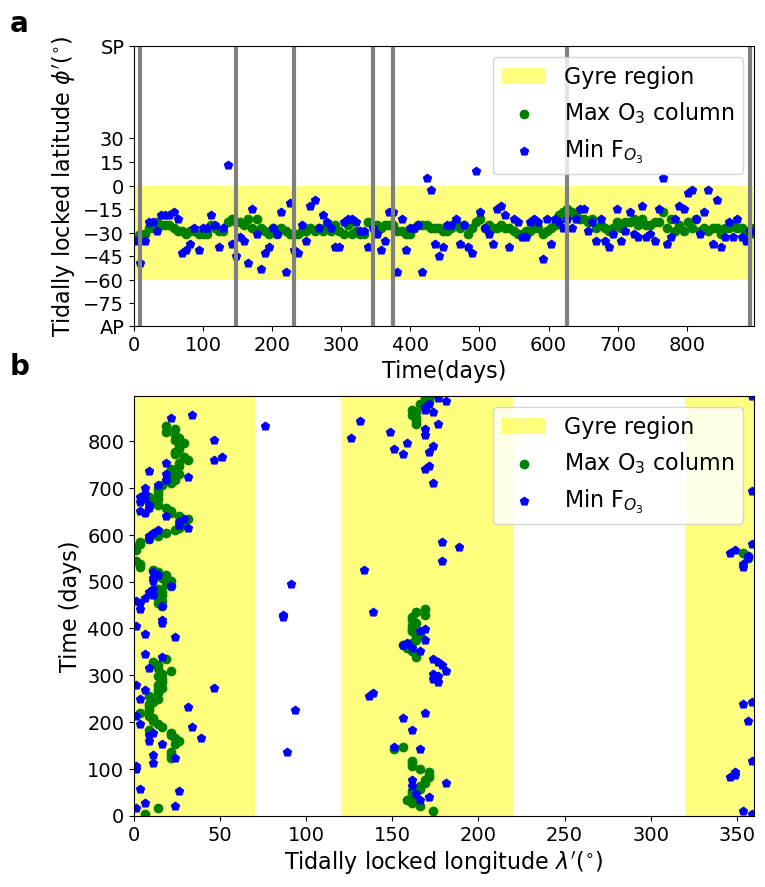

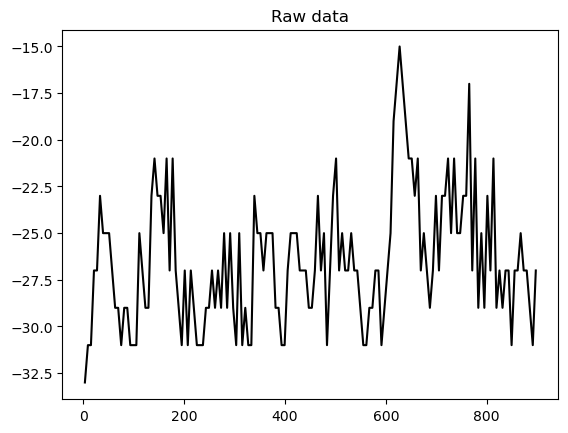

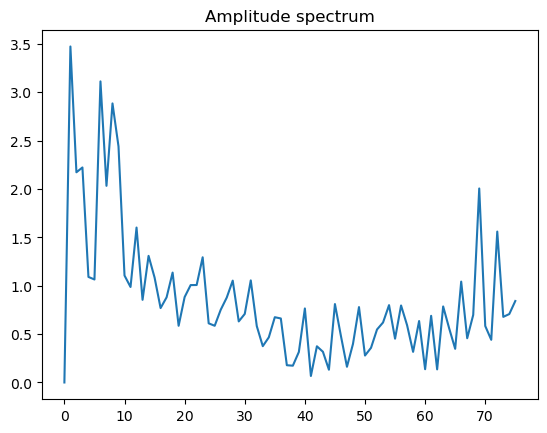

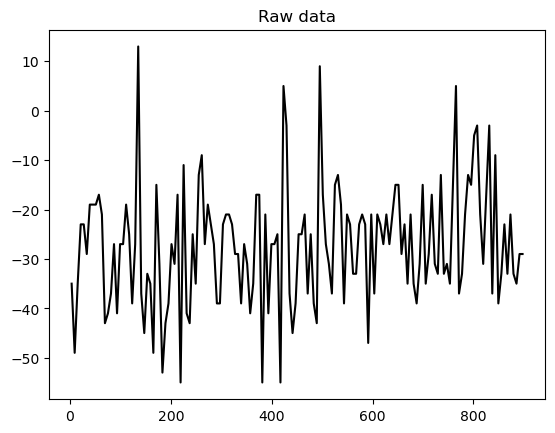

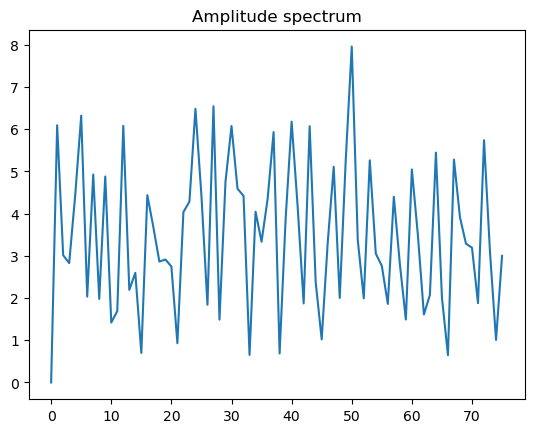

In [17]:
from matplotlib import gridspec
def max_valuelatlon(cubes, time=0, height_level_l=24, height_level=36, sublabel=False, sublabel_t='a', save=False):
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[:,:,:,:].copy()
        if cube.standard_name == 'air_temperature':
            temp_cube = cube[:,:,:,:].copy()
        if cube.standard_name == 'northward_wind':
            y_wind = cube[:,:,:,:].copy()         
        if cube.standard_name =='upward_air_velocity':
            zwind = cube[:,:,:,:].copy()   
        if cube.standard_name =='air_pressure':
            pressure = cube[:,:,:,:].copy()
        if cube.long_name =='O3 MASS MIXING RATIO':
            o3mmr = cube[:,:,:,:].copy()
        if cube.long_name =='Stash code = 50219':
            toc = cube[:,:,:,:].copy()
    height = [('level_height', o3mmr.coord('level_height').points)]
    pressure = pressure.interpolate(height, iris.analysis.Linear())
    zwind = zwind.interpolate(height, iris.analysis.Linear())
    # Regrid so that all three cubes are on the same x, y, z grid. Uses the x_wind as reference for the others
    p_heights = zonal_mean(meridional_mean(pressure))
    km_heights = np.round(pressure.coord('level_height').points*1e-03,1)
    o3mmr = vmr_molec(o3mmr, pressure, temp_cube)
    cube = zwind.copy()
    cube = cube*o3mmr
    #cube = ((o3mmr-zonal_mean(meridional_mean(o3mmr))))
    #cube *= zwind
    #cube = cube/(zonal_mean(meridional_mean(zwind*o3mmr)))
    full_cube_vcol=integrate(cube[:,height_level_l:height_level,:,:], 'level_height')
    time_list=[]
    toc_list=[]
    lat_maxtoc_list=[]
    lon_maxtoc_list=[]
    o3f_list=[]
    lat_mino3f_list=[]
    lon_mino3f_list=[]
    for i in range(0,150):
        toc2=toc[i,0,:,:]
        o3flux=full_cube_vcol[i,:,:]
        max_toc = np.amax(toc2.data)
        max_index = np.unravel_index(np.argmax(toc2.data), toc2.shape)
        lat_maxtoc = toc2.coord('latitude').points[max_index[0]]
        lon_maxtoc = toc2.coord('longitude').points[max_index[1]]

        min_o3flux = np.amin(o3flux.data)
        min_index_o3flux = np.unravel_index(np.argmin(o3flux.data), o3flux.shape)
        lat_mino3flux = o3flux.coord('latitude').points[min_index_o3flux[0]]
        lon_mino3flux = o3flux.coord('longitude').points[min_index_o3flux[1]]
        time_list.append(i)
        toc_list.append(max_toc)
        lat_maxtoc_list.append(lat_maxtoc)
        lon_maxtoc_list.append(lon_maxtoc)
        o3f_list.append(min_o3flux)
        lat_mino3f_list.append(lat_mino3flux)
        lon_mino3f_list.append(lon_mino3flux)
        #print('Maximum spatial value:', max_toc)
        #print('Corrresponding longitude:', lon_maxtoc)
        #print('Corresponding latitude:', lat_maxtoc)
        #print('Minimum spatial value:', max_o3flux)
        #print('Corrresponding longitude:', lon_maxo3flux)
        #print('Corresponding latitude:', lat_maxo3flux)
#     print(time_list)
#     print(toc_list)
#     print(lat_maxtoc_list)
#     print(lon_maxtoc_list)
#     print(o3f_list)
#     print(lat_maxo3f_list)
#     print(lon_maxo3f_list)
    fig = plt.figure(figsize=(8,10))
    gs = gridspec.GridSpec(2,1, height_ratios=[1, 1.5]) 
    ax = fig.add_subplot(gs[0])
    ax.yaxis.set_major_locator(plt.MaxNLocator(7))
    if sublabel==True:
        ax.text(-0.20,1.05, 'a', size=20, weight='bold',transform=ax.transAxes)
    patch=ax.add_patch(Rectangle((0,-60),np.max(toc.coord('t').points),60, facecolor='yellow', alpha=0.5,
                       label='Gyre region'))
    plt.scatter(toc.coord('t').points, lat_maxtoc_list, label='Max O$_3$ column', color='green')
    plt.scatter(toc.coord('t').points, lat_mino3f_list, label='Min F$_{O_3}$', marker='p', color='blue')
    plt.xlabel('Time(days)', fontsize=16)
    plt.ylabel('Tidally locked latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
    plt.axvline(toc[1].coord('t').points, color='grey', lw=3)
    plt.axvline(toc[24].coord('t').points, color='grey', lw=3)
    plt.axvline(toc[38].coord('t').points, color='grey', lw=3)
    plt.axvline(toc[62].coord('t').points, color='grey', lw=3)
    plt.axvline(toc[57].coord('t').points, color='grey', lw=3)
    plt.axvline(toc[148].coord('t').points, color='grey', lw=3)
    plt.axvline(toc[104].coord('t').points, color='grey', lw=3)
    plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
    labels = [w.get_text() for w in ax.get_yticklabels()]
    locs=list(ax.get_yticks())
    labels+=['SP']
    locs+=[89]
    labels+=['AP']
    locs+=[-89]        
    ax.set_yticklabels(labels)
    ax.set_yticks(locs)
    #ax.grid()
    plt.draw()
    plt.ylim(-89,89)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,np.max(pcb_tl_regrid[0].coord('t').points))
    plt.legend(loc='best', fontsize=16)
    ax = fig.add_subplot(gs[1])     
    if sublabel==True:
        ax.text(-0.20,1.05, 'b', size=20, weight='bold',transform=ax.transAxes)
    ax.add_patch(Rectangle((120,0),100,np.max(toc.coord('t').points),facecolor='yellow', alpha=0.5, 
                           label='Gyre region'))
    plt.gca().add_patch(Rectangle((0,0),70,np.max(toc.coord('t').points),facecolor='yellow', alpha=0.5,))
    plt.gca().add_patch(Rectangle((320,0),40,np.max(toc.coord('t').points),facecolor='yellow', alpha=0.5,))
    plt.scatter(lon_maxtoc_list, toc.coord('t').points, label='Max O$_3$ column', color='green')
    plt.scatter(lon_mino3f_list, toc.coord('t').points, label='Min F$_{O_3}$', marker='p',color='blue')    
    plt.ylabel('Time (days)', fontsize=16)
    plt.xlabel('Tidally locked longitude $\lambda^{\prime} (^{\circ})$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0,np.max(toc.coord('t').points))
    plt.xlim(0,360)
    plt.legend(loc='best', fontsize=16)
    if save==True:
        plt.savefig('ex_toc_o3f.pdf', bbox_inches = 'tight')
    plt.show()
    fft_chem(lat_maxtoc_list, toc.coord('t').points)
    fft_chem(lat_mino3f_list, toc.coord('t').points)
max_valuelatlon(pcb_tl_regrid, save=True, sublabel=True)

